<a href="https://colab.research.google.com/github/Spandan-Madan/in_distribution_adversarial_examples/blob/main/demos/demo_rendered_objects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Spandan-Madan/in_distribution_adversarial_examples
!pip install redner-gpu

Cloning into 'in_distribution_adversarial_examples'...
remote: Enumerating objects: 626, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 626 (delta 16), reused 29 (delta 4), pack-reused 569
Receiving objects: 100% (626/626), 91.37 MiB | 13.79 MiB/s, done.
Resolving deltas: 100% (151/151), done.
Updating files: 100% (561/561), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.9/31.9 MB 10.6 MB/s eta 0:00:00


In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, Javascript
import os

In [3]:
import sys
# sys.path.append('../inverse_rendering/')
import torch
from torch.distributions import Normal
from torch.optim.optimizer import Optimizer, required
import numpy as np
import os
from PIL import Image
import torchvision
import sys
import random
import pickle
import copy
from tqdm.notebook import tqdm
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torch
from PIL import Image
import seaborn as sns
import torchvision
from torch import nn


from tqdm import tqdm as tqdm_file
import argparse
import string
import random

In [4]:
from numpy import asarray
from numpy import exp
from numpy import sqrt
from numpy import cos
from numpy import e
from numpy import pi
from numpy import argsort
from numpy.random import randn
from numpy.random import rand
from numpy.random import seed
import pickle

In [5]:
import torch
import torch.nn as nn

In [6]:
# import redner

In [7]:
# import pyredner

In [8]:
ROOT = '/content/in_distribution_adversarial_examples/'
REDNER_ROOT = '/content/in_distribution_adversarial_examples/redner/'

import os
import sys
sys.path.insert(0,ROOT)
sys.path.insert(0,REDNER_ROOT)
import redner
import pyredner


In [9]:
import cma

In [10]:
model_path = os.path.join(ROOT, 'training_models/saved_models/resnet18_pretrained_v7_40_normalized_final.pt')
loaded_model = torch.load(model_path)
softmax_layer = nn.Softmax()

In [11]:
with open('%s/training_models/shapenet_class_num_to_class_name.p'%ROOT,'rb') as F:
    shapenet_class_num_to_class_name = pickle.load(F)
with open('%s/training_models/shapenet_id_to_class_num.p'%ROOT,'rb') as F:
    shapenet_id_to_class_num = pickle.load(F)

In [12]:
RADIUS_MIN = 3.0
RADIUS_MAX = 4.0
MIN_NUM_LIGHTS = 1
MAX_NUM_LIGHTS = 4

RADIUS_MIN_CAM = 1.0
RADIUS_MAX_CAM = 5.0

In [13]:
def generate_uniform_on_sphere(num_points, radius):
    points = []
    for i in range(num_points):
        X = np.random.normal()
        Y = np.random.normal()
        Z = np.random.normal()

        vector = np.array([X,Y,Z])
        point = list(radius*vector/np.linalg.norm(vector))
        points.append(point)
    return points

In [14]:
def get_cam_position(radius_min, radius_max):
    random_radius = random.uniform(radius_min, radius_max)
    cam_point = generate_uniform_on_sphere(1, random_radius)[0]
    cam_point = torch.tensor(cam_point).float()

    return cam_point
def get_positions(min_num_lights, max_num_lights, radius_min, radius_max):
    num_lights = random.choice(range(min_num_lights, max_num_lights + 1))
    light_positions = []

    for num in range(num_lights):
        random_radius = random.uniform(radius_min, radius_max)
        light_point = generate_uniform_on_sphere(1, random_radius)[0]
        light_point = torch.tensor(light_point).float()
        light_positions.append(light_point)

    return light_positions
def get_random_intensity():
    light_intensity = torch.tensor([random.uniform(0,1), \
                                    random.uniform(0,1), random.uniform(0,1)]).float()
    return light_intensity
def get_random_reflectance():
    specular_reflectance = torch.tensor([random.uniform(0,1), \
                                    random.uniform(0,1), random.uniform(0,1)], device = pyredner.get_device()).float()
    return specular_reflectance
def get_random_look_at(radius):
    K = 0.3
    look_at = torch.tensor([random.uniform(0,K*radius), random.uniform(0,K*radius), random.uniform(0,K*radius)]).float()
    return look_at
def get_random_scene_params(model_file):
    ### Random Camera Settings ###
    camera_position = get_cam_position(RADIUS_MIN_CAM, RADIUS_MAX_CAM)
    cam_radius = torch.sqrt(camera_position[0]**2 + camera_position[1]**2 + camera_position[2]**2).item()
    cam_look_at = get_random_look_at(cam_radius)
    fov = torch.tensor(random.uniform(35,100))
    cam_up = torch.tensor([random.uniform(-1,1), random.uniform(-1,1), random.uniform(-1,1)])
    initial_camera_params = {'camera_position': camera_position,
                             'cam_look_at': cam_look_at,
                             'fov': fov,
                             'cam_up': cam_up}


    ### Random Light Settings ###
    all_light_positions = get_positions(MIN_NUM_LIGHTS, MAX_NUM_LIGHTS, RADIUS_MIN, RADIUS_MAX)
    all_light_look_ats = [get_random_look_at(cam_radius) for i in all_light_positions]
    all_light_intensities = [get_random_intensity() for i in all_light_positions]
    all_light_sizes = [torch.tensor([random.uniform(0.1,5.0), random.uniform(0.1, 5.0)]) for i in all_light_positions]
    initial_light_params = {'all_light_positions': all_light_positions,
                            'all_light_look_ats': all_light_look_ats,
                            'all_light_intensities': all_light_intensities,
                            'all_light_sizes': all_light_sizes}

    #### Material ####
    diffuse_material = pyredner.Material(diffuse_reflectance = torch.tensor([1.0, 1.0, 1.0], \
                                        device='cuda:0'), two_sided = True)
    material_settings = {'diffuse_material':diffuse_material}

    scene_params = [model_file, initial_camera_params, initial_light_params, material_settings]
    return scene_params
def show_inputs(inp, save_path = False, title='No Title'):
    plt.imshow(inp[0].cpu().permute(1,2,0).int())
    plt.title(title)
    plt.axis('off')
    if save_path != False:
        plt.savefig(save_path)
    else:
        plt.show()
def render_input(scene):
    img = pyredner.render_pathtracing(scene = scene, num_samples = 256, seed = 1, use_secondary_edge_sampling = False)
    img = torch.clamp(img, min = 0.00000001)
    img = torch.pow(img, 1.0/2.2)
    img = img*255/torch.max(img)
    inputs = img.permute(2,0,1).unsqueeze(0)
    return inputs
def spherical_to_cartesian(r,theta,phi):
    theta_rad = theta*3.14/180
    phi_rad = phi*3.14/180

    x = r * torch.sin(phi_rad) * torch.cos(theta_rad)
    y = r * torch.sin(phi_rad) * torch.sin(theta_rad)
    z = r * torch.cos(phi_rad)
    out =  torch.stack([x,y,z])
    return out
def load_geometry(model_file, geometry, mat):
    if geometry:
        obj_model_all = model_file
        obj_model = [i for i in obj_model_all if len(i.vertices)>0]
    else:
        obj_model_all = pyredner.load_obj(model_file, return_objects=True)
        obj_model = [i for i in obj_model_all if len(i.vertices)>0]

    for part in obj_model:
        part.material = mat

    return obj_model
def optimize_flags(obj):
    if type(obj) == list:
        for o in obj:
            o.requires_grad = True
    else:
        obj.requires_grad = True
    return obj
def setup_scene(scene_params):

    model_file, camera_params, light_params, material_settings = scene_params
    obj_model = load_geometry(model_file, False, material_settings['diffuse_material'])

    #### Camera Setup ####
    scene_cam = pyredner.automatic_camera_placement(obj_model, resolution = (224, 224),
                                                   fov = torch.tensor([camera_params['fov']]),
                                                   up = camera_params['cam_up'],
                                                   look_at = camera_params['cam_look_at'])
    scene_cam.position = camera_params['camera_position']

    #### Lights Setup ####
    scene_lights = []
    num_lights = len(light_params['all_light_positions'])
    for i in range(num_lights):
        scene_light = pyredner.generate_quad_light(position = light_params['all_light_positions'][i],
                                     look_at = light_params['all_light_look_ats'][i],
                                     size = light_params['all_light_sizes'][i],
                                     intensity = light_params['all_light_intensities'][i],
                                     directly_visible = False)
        scene_lights.append(scene_light)

    all_objects = obj_model + scene_lights
    scene = pyredner.Scene(objects = all_objects, camera = scene_cam)

    return scene
def start_up(scene_params, optimized_params):
    model_file, camera_params, light_params, material_settings = scene_params
    variables = []
    var_names_list = []
    for param in optimized_params:
        if param in camera_params.keys():
            optimize_flags(camera_params[param])
            if type(camera_params[param]) == list:
                variables.extend(camera_params[param])
            else:
                variables.append(camera_params[param])
        elif param in light_params.keys():
            optimize_flags(light_params[param])
            if type(light_params[param]) == list:
                variables.extend(light_params[param])
            else:
                variables.append(light_params[param])

    scene_params = [model_file, camera_params, light_params, material_settings]
    scene = setup_scene(scene_params)

    return scene, variables

def perturbation_vector(factor_len, perturb_percent = 1):
    if factor_len == 0:
        factor_len = 1
    vec = torch.tensor([random.uniform(-perturb_percent/100,perturb_percent/100) for i in range(factor_len)])
    return 1 + vec
def random_perturbed_params(scene_params, perturb_percent = 1):
    new_scene_params = [0,0,0,0]
    new_scene_params[0] = scene_params[0]

    new_scene_params[1] = {}
    for key in scene_params[1].keys():
        new_scene_params[1][key] = scene_params[1][key].clone() * perturbation_vector(scene_params[1][key].dim(), perturb_percent)

    new_scene_params[2] = {}
    for key in scene_params[2].keys():
        new_scene_params[2][key] = [i.clone() * perturbation_vector(i.dim(), perturb_percent) for i in scene_params[2][key]]

    new_scene_params[3] = scene_params[3]
    return new_scene_params
def render_and_predict(scene_params, optimized_params):
    scene, variables = start_up(scene_params, optimized_params)
    inputs = render_input(scene)
    inputs = inputs.cuda()
    rendered_inputs = inputs.clone()
    inputs = inputs/255.0
    im_means = torch.mean(inputs).unsqueeze(0).unsqueeze(1).unsqueeze(1).unsqueeze(1)
    im_stds = torch.std(inputs).unsqueeze(0).unsqueeze(1).unsqueeze(1).unsqueeze(1)
    inputs_ = (inputs - im_means)/im_stds
    outputs = softmax_layer(loaded_model(inputs_))
    prediction = torch.argmax(outputs).item()
    return prediction, rendered_inputs
def create_folder(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)
def clone_scene_params(scene_params):
    original_scene_params = [0,0,0,0]
    original_scene_params[0] = scene_params[0]

    original_scene_params[1] = {}
    for key in scene_params[1].keys():
        original_scene_params[1][key] = scene_params[1][key].clone()

    original_scene_params[2] = {}
    for key in scene_params[2].keys():
        original_scene_params[2][key] = [i.clone() for i in scene_params[2][key]]

    original_scene_params[3] = scene_params[3]
    return original_scene_params

def plot_losses(losses):
    plt.plot(losses, marker='o',color='green')
    plt.title('Losses',fontsize=16)
    plt.xticks(fontsize= 12)
    plt.yticks(fontsize= 12)
    plt.show()

def check_in_range(scene_params):
    if scene_params[0] == 0:
        return False
    cam_radius = torch.norm(scene_params[1]['camera_position'])
    radius_check = RADIUS_MIN_CAM <= cam_radius <= RADIUS_MAX_CAM
    look_at_check = torch.sum(scene_params[1]['cam_look_at'] < cam_radius*0.3).item() == 3
    return radius_check and look_at_check

def objective(scene_params, optimized_params, neuron_num = None):
    scene, variables = start_up(scene_params, [])
    inputs = render_input(scene)
    inputs = inputs.cuda()
    rendered_inputs = inputs.clone()
    inputs = inputs/255.0
    im_means = torch.mean(inputs).unsqueeze(0).unsqueeze(1).unsqueeze(1).unsqueeze(1)
    im_stds = torch.std(inputs).unsqueeze(0).unsqueeze(1).unsqueeze(1).unsqueeze(1)
    inputs_ = (inputs - im_means)/im_stds
    outputs = shorter_model(inputs_)
    if neuron_num is None:
        selective_neurons = torch.argsort(outputs[0].view(512,-1).squeeze(1))[-1]
        selected_act_firing = outputs[0].view(512,-1).squeeze(1)[selective_neurons]
        return selective_neurons, selected_act_firing
    else:
        loss = torch.sum(outputs[0].view(512,-1).squeeze(1)[neuron_num]).item()
    return loss



def cma_objective_adversarial(x):
    SCENE_PARAMS[1]['camera_position'] = torch.tensor(x[:3]).float()
    SCENE_PARAMS[1]['cam_look_at'] = torch.tensor(x[3:6]).float()
    SCENE_PARAMS[1]['cam_up'] = torch.tensor(x[6:9]/10).float()
    SCENE_PARAMS[1]['fov'] = torch.tensor(x[9]*10).float()

    scene, variables = start_up(SCENE_PARAMS, [])
    inputs = render_input(scene)
    inputs = inputs.cuda()
    rendered_inputs = inputs.clone()
    inputs = inputs/255.0
    im_means = torch.mean(inputs).unsqueeze(0).unsqueeze(1).unsqueeze(1).unsqueeze(1)
    im_stds = torch.std(inputs).unsqueeze(0).unsqueeze(1).unsqueeze(1).unsqueeze(1)
    inputs_ = (inputs - im_means)/im_stds
    outputs = loaded_model(inputs_)
    probability = outputs[0][CATEGORY_NUM].item()
    prediction = torch.argmax(outputs[0]).item()
    return probability, prediction

In [15]:
model_files_pickle = '%s/rendering/shapenet_model_subsets/categories_10_models_40.pkl'%ROOT
with open(model_files_pickle, 'rb') as F:
    model_files = pickle.load(F)

In [16]:
def get_random_3d_model():
#     categories_10_models_10.pkl
    model_files_pickle = '../rendering/shapenet_model_subsets/%s'%MODELS_PICKLE_FILE_NAME
    with open(model_files_pickle, 'rb') as F:
        model_files = pickle.load(F)
    random_category = random.choice(list(model_files.keys()))
    random_instance = random.choice(model_files[random_category]).split('/')[7]
    model_file = '%s/ShapeNetCore.v2/%s/%s/models/model_normalized.obj'%(user_root_dir, random_category, random_instance)
    print('Chosen model is a %s'%shapenet_class_num_to_class_name[shapenet_id_to_class_num[random_category]])
    category_num = shapenet_id_to_class_num[random_category]
    print('Category num is %s'%category_num)
    return model_file, category_num, random_category, random_instance

In [17]:
model_file = '%s/rendering/shapenet_model_subsets/subset_models/04379243_cf7c2cfb403f2819548cdb167cc8bdd/models/model_normalized.obj'%ROOT
category = '04379243'
instance = 'cf7c2cfb403f2819548cdb167cc8bdd'
category_num = shapenet_id_to_class_num[category]
print('Chosen model is a %s'%shapenet_class_num_to_class_name[shapenet_id_to_class_num[category]])
print('Category number is %s'%category_num)

Chosen model is a table
Category number is 10


In [18]:
import os
import sys
sys.path.insert(0,'%s/redner/'%ROOT)
import redner
import pyredner

In [19]:
pyredner.__file__

'/content/in_distribution_adversarial_examples/redner/pyredner/__init__.py'

In [20]:
optimized_params = []
curr_pred = -1
while curr_pred != category_num:
    scene_params = get_random_scene_params(model_file)
    original_scene_params = clone_scene_params(scene_params)
    curr_pred, _ = render_and_predict(scene_params, [])

/content/in_distribution_adversarial_examples/redner/pyredner/render_pytorch.py:214: UserWarning: Converting shape vertices from cpu to cuda:0, this can be inefficient.
  warnings.warn('Converting shape vertices from {} to {}, this can be inefficient.'.format(shape.vertices.device, device))
/content/in_distribution_adversarial_examples/redner/pyredner/render_pytorch.py:216: UserWarning: Converting shape indices from cpu to cuda:0, this can be inefficient.
  warnings.warn('Converting shape indices from {} to {}, this can be inefficient.'.format(shape.indices.device, device))
/content/in_distribution_adversarial_examples/redner/pyredner/render_pytorch.py:55: UserWarning: Converting texture from cpu to cuda:0, this can be inefficient.
  warnings.warn('Converting texture from {} to {}, this can be inefficient.'.format(mipmap.device, device))


Scene construction, time: 29.15305 s
Forward pass, time: 0.37519 s


<ipython-input-14-e5bf47f53d01>:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = softmax_layer(loaded_model(inputs_))


Scene construction, time: 0.04208 s
Forward pass, time: 0.40112 s
Scene construction, time: 0.04439 s
Forward pass, time: 0.40878 s


In [21]:
orig_im = _[0].clone()

In [22]:
cp = np.array(scene_params[1]['camera_position'])
cat = np.array(scene_params[1]['cam_look_at'])
cup = np.array(scene_params[1]['cam_up'])*10
fov = np.array(scene_params[1]['fov'])/10
start_pos = np.hstack([cp,cat,cup,fov])

In [23]:
SCENE_PARAMS = clone_scene_params(scene_params)
CATEGORY_NUM = category_num

es = cma.CMAEvolutionStrategy(start_pos, 0.05)

es.optimize(cma_objective_adversarial, verb_disp = True, iterations=15, correct_prediction = category_num)
print(es.predictions)

Scene construction, time: 0.04348 s
Forward pass, time: 0.38482 s
Scene construction, time: 0.04271 s
Forward pass, time: 0.38427 s
Scene construction, time: 0.04211 s
Forward pass, time: 0.36859 s
Scene construction, time: 0.04240 s
Forward pass, time: 0.37673 s
Scene construction, time: 0.04497 s
Forward pass, time: 0.36189 s
Scene construction, time: 0.04259 s
Forward pass, time: 0.37403 s
Scene construction, time: 0.04259 s
Forward pass, time: 0.38038 s
Scene construction, time: 0.04259 s
Forward pass, time: 0.36514 s
Scene construction, time: 0.04220 s
Forward pass, time: 0.36503 s
Scene construction, time: 0.04390 s
Forward pass, time: 0.36249 s
Adversarial found, should stop now.
Predictions are :[1, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.661782264709473e+00 1.0e+00 4.78e-02  4e-02  5e-02 0:32.0
Adversarial found, trying to stop.
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[

In [24]:
info_to_store = {}

info_to_store['scene_params'] = scene_params
info_to_store['es'] = es

In [25]:
orig_scene, variables = start_up(SCENE_PARAMS,[])

In [26]:
new_scene, variables = start_up(scene_params, [])

In [27]:
def render_input_new(scene):
    img = pyredner.render_pathtracing(scene = scene, num_samples = 512, seed = 1)
    img = torch.clamp(img, min = 0.00000001)
    img = torch.pow(img, 1.0/2.2)
    img = img*255/torch.max(img)
    inputs = img.permute(2,0,1).unsqueeze(0)
    return inputs, img

In [28]:
orig_inputs, orig_img = render_input_new(orig_scene)

Scene construction, time: 0.04940 s
Forward pass, time: 0.65605 s


In [29]:
new_inputs, new_img = render_input_new(new_scene)

Scene construction, time: 0.03195 s
Forward pass, time: 0.55612 s


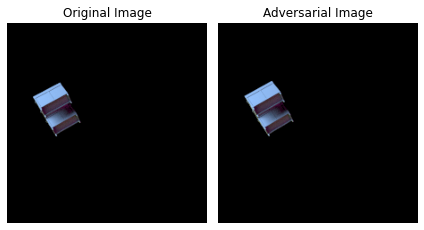

In [30]:
plt.figure(figsize=(6,12))
plt.subplot(1,2,1)
plt.imshow(orig_img.detach().cpu()/255.0)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(new_img.detach().cpu()/255.0)
plt.title('Adversarial Image')
plt.axis('off')
plt.tight_layout()
plt.show()